In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
import sdeint
import seaborn as sns
sns.set(
    context='paper',
    style='ticks',
    palette='Set1',
    font_scale=2
)

def fig_xlabel(fig, label, x=0.5, y=0):
    return fig.text(x, y, label, horizontalalignment='center', verticalalignment='bottom')

def fig_ylabel(fig, label, x=0, y=0.5):
    return fig.text(x, y, label, rotation='vertical', horizontalalignment='right', verticalalignment='center')

def fig_panel_labels(axes, letters='ABCDEFGHIJKLMNOP', xcoord=-0.17, ycoord=0.92, panel_label_size=plt.rcParams[ 'axes.titlesize']*1.3):
    return [
        ax.annotate(letter, (xcoord, ycoord), xycoords='axes fraction', fontsize=panel_label_size)
        for ax, letter 
        in zip(axes.flat, letters)
    ]

$$
x' = \frac{x \omega_A ((1-\eta)x + \eta) + (1-x) \omega_B (1-\eta) x}{x \omega_A + (1-x) \omega_B} \\
\mu(x) = \eta x (1-x) \frac{\omega_A - \omega_B}{x \omega_A + (1-x) \omega_B} \\
\sigma^2(x) = \eta^2 x (1-x) \frac{(1-x) \omega_A + x \omega_B}{x \omega_A + (1-x) \omega_B} \\
$$

In [3]:
def recurrence(x, t, η, ε, W, w):
    ωA, ωB = (W, w) if ε[t] == 0 else (w, W)
    meanω = x * ωA + (1 - x) * ωB
    return (x * ωA * ( (1 - η) * x + η) + (1 - x) * ωB * (1 - η) * x) / meanω

def μ(x, t, η, ε, W, w):
    ωA, ωB = (W, w) if ε[t] == 0 else (w, W)
    meanω = x * ωA + (1 - x) * ωB
    return η * x * (1 - x) * (ωA - ωB) / meanω
    
def σ2(x, t, η, ε, W, w):
    ωA, ωB = (W, w) if ε[t] == 0 else (w, W)
    meanω = x * ωA + (1 - x) * ωB
    return η**2 * x * (1 - x) * ((1 - x) * ωA + x * ωB )

def dxdt(x, t, η, ε, W, w):
    t = min(ε.size - 1, int(round(t, 0)))
    ωA, ωB = (W, w) if ε[t] == 0 else (w, W)
    meanω = x * ωA + (1 - x) * ωB
    return η * x * (1 - x) * (ωA - ωB) / meanω

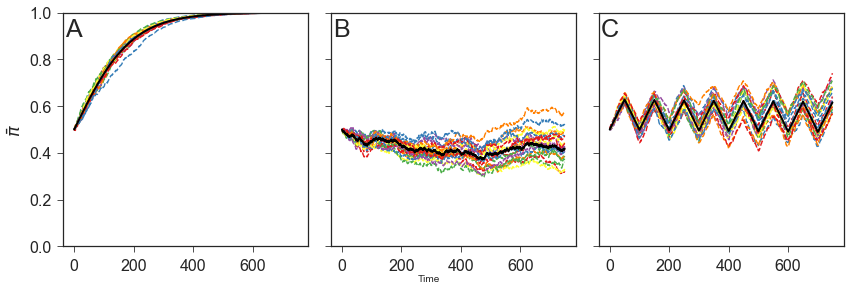

In [99]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

reps = 20
η, W, w = 0.1, 1, 0.9
t = np.arange(750, dtype=int)
x0 = 0.5
envs = [
    np.zeros(t.size), 
    np.random.randint(0, 2, t.size), 
    np.array(([0] * 50 + [1] * 50)*10)
]

for ax, ε, letter in zip(axes.flat, envs, 'ABCDEFG'):
    params = η, ε, W, w
    # recurrence
    x_r = np.empty_like(t, dtype=float)
    x_r[0] = x0
    for i in range(1, t.size):
        x_r[i] = recurrence(x_r[i - 1], i - 1, *params)
    # ode
#     x_o = odeint(dxdt, x0, t, args=params)    
    # diffusion
    x_d = np.array([
        sdeint.itoint(
            lambda x, t: μ(x, t, *params), 
            lambda x, t: σ2(x, t, *params), 
            x0, 
            t
        )
        for _ in range(reps)
    ]).squeeze().T
    # plot
    ax.plot(t, x_d, ls='--', label='diffusion')
    ax.plot(t, x_r, ls='-', lw=2, color='k', label='recurrence')
#     ax.plot(t, x_o, ls='-', label='ode')

# axes[0].legend()
axes[0].set(
    ylim=(0, 1),
    ylabel=r'$\bar{\pi}$'
)
fig_panel_labels(axes, xcoord=0.01, ycoord=0.9)
fig_xlabel(fig, 'Time')
fig.tight_layout()
plt.savefig('../figures/sde_example.pdf')

# Constant environment $\omega_A=W, \omega_B=w$

This doesn't really work, the estimated fixation probabilities do not align with simulations...

$$
A(x) = 
\int_{0}^{x}{\frac{2 \mu(z)}{\sigma^2(z)} dz} = 
\frac{2}{\eta} \cdot \log{\Big( \frac{W}{(1-x)W + xW} \Big)}
$$

In [5]:
def A(x, η, W, w):
    return 2/η * np.log(W/((1-x)*W + x*w))

In [8]:
A(0.1, 0.1, 1, 0.1)

1.8862135894248242

$$
S(x) =
\int{e^{-A(x)}dx} = \\
-\frac{η W^{-2/\eta} \Big((1-x) W + x w\Big)^{1+\frac{2}{η}} }{(W - w) (2 + η)} + C
$$

$C$ doesn't matter as I will always use difference between $S(x) - S(y)$, therefore set $C=0$.

In [24]:
def S(x, η, W, w):
    num = η * W**(-2/η) * ((1-x) * W + x * w)**(1+2/η)
    denom = (W - w) * (2 + η)
    return - num / denom

In [25]:
S(1, 0.1, 1, 0.1), S(0, 0.1, 1, 0.1)

(-5.2910052910052974e-23, -0.05291005291005291)

In [26]:
@np.vectorize
def u(x0, η, W, w):
    p = η, W, w
    up = S(x0, *p) - S(0, *p)
    down = S(1, *p) - S(0, *p)
    assert down > 0, (x0, *p)
    return up / down

@np.vectorize
def v(x0, η, W, w):
    return 1 - u(x0, η, W, w)

In [32]:
u(0, 0.1, 1.0, 0.1), u(1, 0.1, 1.0, 0.1), u(0.5, 0.1, 1.0, 0.1)

(array(0.0), array(1.0), array(0.9999964712858466))

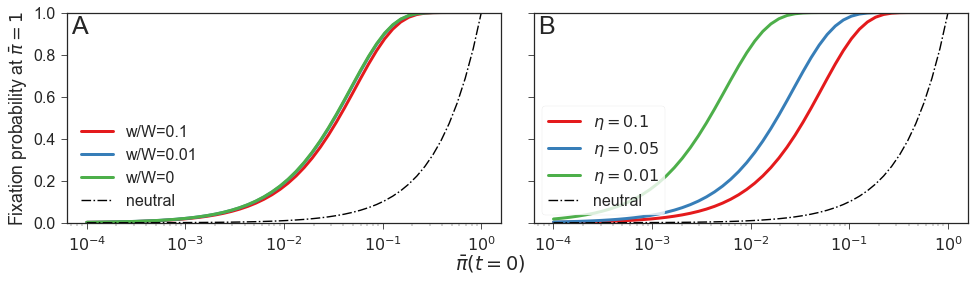

In [34]:
x0 = np.logspace(-4, 0)

fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharex=True, sharey=True)

axes[0].plot(x0, u(x0, 0.1, 1, 0.1), lw=3, label='w/W=0.1')
axes[0].plot(x0, u(x0, 0.1, 1, 0.01), lw=3, label='w/W=0.01')
axes[0].plot(x0, u(x0, 0.1, 1, 0), lw=3, label='w/W=0')
axes[0].plot(x0, x0, ls='-.', color='k', label='neutral')
axes[0].legend(loc='lower left')

axes[1].plot(x0, u(x0, 0.1, 1, 0.1), lw=3, label=r'$\eta=0.1$')
axes[1].plot(x0, u(x0, 0.05, 1, 0.1), lw=3, label=r'$\eta=0.05$')
axes[1].plot(x0, u(x0, 0.01, 1, 0.1), lw=3, label=r'$\eta=0.01$')
axes[1].plot(x0, x0, ls='-.', color='k', label='neutral')
axes[1].legend(loc='lower left', frameon=True)

axes[0].set_xscale('log')
axes[0].set_ylim(0,1)
axes[0].set_ylabel(r'Fixation probability at $\bar{\pi}=1$')
fig_panel_labels(axes, xcoord=0.01, ycoord=0.9)
fig_xlabel(fig, r'$\bar{\pi}(t=0)$')
fig.tight_layout()
# plt.savefig('../figures/diffusion_fix_prob.pdf')

In [96]:
reps = 10
N = 100000
η, W, w = 0.1, 1, 0.1
t = np.arange(1000, dtype=int)
x0 = 0.01
ε = np.zeros(t.size)
params = η, ε, W, w
x = np.array([
    sdeint.itoint(
        lambda x, t: μ(x, t, *params), 
        lambda x, t: σ2(x, t, *params), 
        x0, 
        t
    )
    for _ in range(reps)
]).squeeze().T

In [97]:
(x[-1,:] < 1/N).mean()

0.0

0.17292147571250327


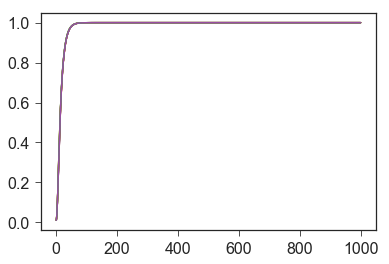

In [98]:
plt.plot(t, x)
print(u(x0, η, W, w))

In [50]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('../src/')
from simulation import *

In [93]:
π = simulation(1000000, 1000, η, 0, W, w, π0=lambda N: np.ones(N)*x0, ε=ε)

../src/simulation.py:82: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  ω_t = ω[ϵ_, φ]


KeyboardInterrupt: 

In [ ]:
plt.hist(π[-1, :])

In [ ]:
plt.plot(π.mean(axis=1))